In [1]:
import pandas as pd
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications import EfficientNetB0,VGG16
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [2]:
csv_file_path = "E:\/통합_신체정보데이터.csv"
df = pd.read_csv (csv_file_path,encoding='utf8')
df

,model_num,height,weight,body_fat,waist,belly_waist,hip,thigh,bust,arm,shoulder,insim,gender,age,body_shape
0,F004,164.1,49.4,21.8,64.1,67.2,87.8,50.3,80.5,24.8,33.5,75.4,F,30,모래시계형 (Hourglass)
1,F005,152.9,51.9,24.2,66.2,79.2,90.5,55.0,80.5,29.2,33.1,63.3,F,44,배형 (Belly)
2,F006,159.7,47.6,20.0,64.4,74.5,87.3,47.6,79.5,25.1,32.1,66.5,F,50,배형 (Belly)
3,F007,162.2,59.1,27.8,74.8,82.3,92.1,52.2,93.0,26.7,33.6,70.6,F,42,배형 (Belly)
4,F008,157.6,61.6,36.4,82.6,89.0,92.2,51.5,99.7,29.0,36.6,66.6,F,65,사과형 (Apple)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
987,M499,169.9,65.2,17.8,81.8,82.0,87.0,48.4,92.7,29.3,39.1,69.1,M,53,사과형 (Apple)
988,M500,173.7,67.2,20.3,72.3,77.0,93.9,55.3,91.7,31.9,39.0,74.8,M,30,모래시계형 (Hourglass)
989,F013,152.0,74.0,50.5,99.7,104.8,105.4,64.4,101.9,32.8,33.8,65.0,F,50,사과형 (Apple)
990,F014,160.2,51.2,25.0,68.5,77.0,89.0,52.2,81.0,25.8,35.8,68.4,F,57,배형 (Belly)


In [3]:
df.isnull().sum()

model_num      0
height         0
weight         0
body_fat       0
waist          0
belly_waist    0
hip            0
thigh          0
bust           0
arm            0
shoulder       0
insim          0
gender         0
age            0
body_shape     0
dtype: int64

In [4]:
import os
import numpy as np
import pandas as pd
from tensorflow.keras.applications import EfficientNetB0, VGG16
from tensorflow.keras.applications.efficientnet import preprocess_input as eff_preprocess
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_preprocess
from tensorflow.keras.preprocessing import image

# 이미지 데이터 경로
image_dir = "E:/image_data/"

# EfficientNetB0 & VGG16 모델 로드
eff_model = EfficientNetB0(weights="imagenet", include_top=False, pooling="avg")
vgg_model = VGG16(weights="imagenet", include_top=False, pooling="avg")

# 이미지 로드 및 전처리 함수
def load_and_preprocess_image(img_path, preprocess_func):
    """이미지를 로드하고 CNN 모델에 맞게 전처리"""
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_func(img_array)  # 모델별 전처리 함수 적용
    return img_array

# EfficientNetB0 & VGG16 특징 벡터 추출 함수
def extract_features_for_model(model_num):
    """각 model_num에 해당하는 16개 이미지에서 EfficientNetB0 & VGG16 특징 벡터 추출"""
    eff_features_list = []
    vgg_features_list = []

    for i in range(1, 17):  # 1~16 이미지 로드
        img_filename = f"resize_{model_num}_{i}.jpg"
        img_path = os.path.join(image_dir, img_filename)

        if os.path.exists(img_path):
            # EfficientNetB0 특징 벡터 추출
            img_array_eff = load_and_preprocess_image(img_path, eff_preprocess)
            eff_features = eff_model.predict(img_array_eff).flatten()
            eff_features_list.append(eff_features)

            # VGG16 특징 벡터 추출
            img_array_vgg = load_and_preprocess_image(img_path, vgg_preprocess)
            vgg_features = vgg_model.predict(img_array_vgg).flatten()
            vgg_features_list.append(vgg_features)
        else:
            print(f"이미지 없음: {img_path}")
            return None, None  # 한 개라도 없으면 무효 처리

    # 16개 이미지의 평균 벡터 계산
    if eff_features_list and vgg_features_list:
        return np.mean(eff_features_list, axis=0), np.mean(vgg_features_list, axis=0)  # 평균값 사용
    return None, None

# CSV 데이터 불러오기 (신체 측정값)
df = pd.read_csv("E://통합_신체정보데이터.csv")

# CNN 특징 벡터 추가
feature_data = []
missing_models = []  # 누락된 모델 저장 리스트

for index, row in df.iterrows():
    model_num = row["model_num"]  # 모델 ID 가져오기
    eff_features, vgg_features = extract_features_for_model(model_num)

    if eff_features is not None and vgg_features is not None:
        combined_data = np.concatenate([
            [model_num],  # model_num 포함
            eff_features,  # EfficientNetB0 특징 벡터 (1280차원)
            vgg_features,  # VGG16 특징 벡터 (512차원)
            row[["height", "weight", "belly_waist", "waist", "hip", "thigh", "bust", "shoulder"]].values  # 신체 측정값
        ])
        feature_data.append(combined_data)
    else:
        missing_models.append(model_num)  # 이미지 누락된 model_num 저장

# 데이터프레임 변환
columns = ["model_num"] + \
          [f"eff_feature_{i}" for i in range(len(eff_features))] + \
          [f"vgg_feature_{i}" for i in range(len(vgg_features))] + \
          ["height", "weight", "belly_waist", "waist", "hip", "thigh", "bust", "shoulder"]

final_df = pd.DataFrame(feature_data, columns=columns)

# 결과 확인
print("EfficientNetB0 + VGG16 특징 벡터 추출 완료")
print(final_df.head())  # 상위 5개 출력

# CSV 저장
final_df.to_csv("CNN_특징벡터_신체데이터.csv", index=False)

# 누락된 모델 출력
if missing_models:
    print(f"누락된 모델 {len(missing_models)}개:", missing_models)


이미지 없음: E:/image_data/resize_F004_1.jpg
이미지 없음: E:/image_data/resize_F005_1.jpg
이미지 없음: E:/image_data/resize_F006_1.jpg
이미지 없음: E:/image_data/resize_F007_1.jpg
이미지 없음: E:/image_data/resize_F008_1.jpg
1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 24ms/step
이미지 없음: E:/image_data/resize_M004_1.jpg
이미지 없음: E:/image_data/resize_M005_1.jpg
이미지 없음: E:/image_data/resize_M006_1.jpg
이미지 없음: E:/image_data/resize_M007_1.jpg
이미지 없음: E:/image_data/resize_M008_1.jpg
1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 64ms/step


1/1 [==============================] - 0s 36ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 36ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 37ms/step


1/1 [==============================] - 0s 36ms/step
EfficientNetB0 + VGG16 특징 벡터 추출 완료
  model_num  eff_feature_0  eff_feature_1  eff_feature_2  eff_feature_3  \
0      F009      -0.099347      -0.038895      -0.094854       0.092622   
1      F010      -0.098292      -0.100162      -0.081625       0.072672   
2      F011      -0.113810      -0.069378      -0.075031       0.035652   
3      F012      -0.134891      -0.024253      -0.097606       0.149487   
4      F016      -0.093220      -0.119580      -0.084529       0.097382   

   eff_feature_4  eff_feature_5  eff_feature_6  eff_feature_7  eff_feature_8  \
0       0.042953       0.542635       0.059078       0.221374       0.046118   
1      -0.070710       0.325618       0.251018       0.475114       0.053832   
2      -0.105666       0.394504       0.087152       0.479451      -0.000230   
3      -0.085218       0.205101       0.107380       0.444742       0.063044   
4      -0.104430       0.418802       0.249590       0.631410 

In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import xgboost as xgb

# CSV 데이터 불러오기
file_path = "CNN_특징벡터_신체데이터.csv"
df = pd.read_csv(file_path)
df = df.drop(columns=["model_num"], errors="ignore")  # "model_num"이 있으면 제거
# 특징 벡터 (X)와 타겟 데이터 (Y) 분리
X = df.iloc[:, :-8].values  # EfficientNetB0 + VGG16 특징 벡터
y = df[["height", "weight", "belly_waist", "waist", "hip", "thigh", "bust", "shoulder"]].values  # 신체 측정값

# 훈련/검증 데이터 분리 (80% 훈련, 20% 검증)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("훈련 데이터 크기:", X_train.shape, "검증 데이터 크기:", X_test.shape)


훈련 데이터 크기: (785, 1792) 검증 데이터 크기: (197, 1792)


In [8]:
# 훈련 & 검증 데이터 학습 과정 출력
# XGBoost용 DMatrix 변환 (XGB.train()을 사용하려면 필요)
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# XGBoost 모델 파라미터 설정
params = {
    "objective": "reg:squarederror",
    "eval_metric": ["mae", "rmse"],  # MAE와 RMSE를 모두 평가 지표로 사용
    "learning_rate": 0.05,
    "max_depth": 6,
    "num_boost_round": 200,
    "random_state": 42
}

# 학습 과정 저장할 딕셔너리 생성
evals_result = {}

# 학습 실행 (early stopping 포함)
model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=200,  # 트리 개수
    evals=[(dtrain, "train"), (dtest, "test")],  # 학습 및 검증 데이터 설정
    early_stopping_rounds=10,  # 10회 이상 성능 개선 없으면 조기 종료
    evals_result=evals_result,  # 학습 과정 저장
    verbose_eval=True  # 학습 로그 출력
)


C:\ai\IDE\anaconda\lib\site-packages\xgboost\core.py:158: UserWarning: [20:46:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "num_boost_round" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	train-mae:25.02187	train-rmse:34.68064	test-mae:25.15028	test-rmse:34.79241
[1]	train-mae:23.80676	train-rmse:32.97854	test-mae:23.99881	test-rmse:33.11965
[2]	train-mae:22.65356	train-rmse:31.36199	test-mae:22.90243	test-rmse:31.52966
[3]	train-mae:21.55847	train-rmse:29.82658	test-mae:21.86744	test-rmse:30.02191
[4]	train-mae:20.51458	train-rmse:28.36709	test-mae:20.87327	test-rmse:28.58861
[5]	train-mae:19.52521	train-rmse:26.98093	test-mae:19.94190	test-rmse:27.23529
[6]	train-mae:18.58534	train-rmse:25.66361	test-mae:19.04869	test-rmse:25.94561
[7]	train-mae:17.69013	train-rmse:24.41206	test-mae:18.20493	test-rmse:24.72539
[8]	train-mae:16.83942	train-rmse:23.22299	test-mae:17.41110	test-rmse:23.57216
[9]	train-mae:16.03146	train-rmse:22.09335	test-mae:16.66060	test-rmse:22.48335
[10]	train-mae:15.26266	train-rmse:21.01993	test-mae:15.94641	test-rmse:21.44682
[11]	train-mae:14.53341	train-rmse:20.00020	test-mae:15.25565	test-rmse:20.45975
[12]	train-mae:13.83933	train-rmse:19.

[106]	train-mae:0.40312	train-rmse:0.74995	test-mae:3.53271	test-rmse:5.38932
[107]	train-mae:0.39489	train-rmse:0.74192	test-mae:3.53009	test-rmse:5.38726
[108]	train-mae:0.38677	train-rmse:0.73448	test-mae:3.52830	test-rmse:5.38602
[109]	train-mae:0.37949	train-rmse:0.72766	test-mae:3.52673	test-rmse:5.38439
[110]	train-mae:0.37265	train-rmse:0.72111	test-mae:3.52544	test-rmse:5.38305
[111]	train-mae:0.36554	train-rmse:0.71470	test-mae:3.52402	test-rmse:5.38163
[112]	train-mae:0.35853	train-rmse:0.70829	test-mae:3.52255	test-rmse:5.38045
[113]	train-mae:0.35158	train-rmse:0.70201	test-mae:3.52068	test-rmse:5.37916
[114]	train-mae:0.34509	train-rmse:0.69641	test-mae:3.51950	test-rmse:5.37807
[115]	train-mae:0.33878	train-rmse:0.69106	test-mae:3.51833	test-rmse:5.37720
[116]	train-mae:0.33279	train-rmse:0.68585	test-mae:3.51697	test-rmse:5.37629
[117]	train-mae:0.32713	train-rmse:0.68116	test-mae:3.51606	test-rmse:5.37586
[118]	train-mae:0.32123	train-rmse:0.67627	test-mae:3.51447	test

In [9]:
# 예측 수행
dtest = xgb.DMatrix(X_test)
y_pred = model.predict(dtest)

In [10]:
mae = mean_absolute_error(y_test,y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f'mae:{mae:.2f},rmse:{rmse:.2f},r2:{r2:.2f}')

mae:3.48,rmse:5.35,r2:0.53


In [11]:
import numpy as np
num_samples = 5
print("실제값 vs 예측값 비교:")
for i in range(num_samples):
    print(f"실제: {y_test[i]}, 예측: {np.round(y_pred[i], 2)}")

실제값 vs 예측값 비교:
실제: [171.6  98.5 103.   99.7 110.   66.2 112.4  39.7], 예측: [172.72  79.84  93.18  90.96  95.62  57.68  97.97  40.32]
실제: [173.5  79.6  92.4  92.2  97.2  59.2  98.9  36.4], 예측: [174.17  76.07  93.45  91.48  95.42  55.41  96.84  39.43]
실제: [168.4  66.1  86.4  88.3  89.2  49.2  90.8  38.2], 예측: [167.75  68.26  86.14  83.84  93.04  53.08  92.65  38.37]
실제: [174.6  68.7  84.4  79.7  95.8  58.1  84.1  39.4], 예측: [171.11  68.1   86.32  77.62  95.34  56.89  93.54  38.84]
실제: [162.1  90.9 103.6 104.3 111.   66.3 114.8  37.3], 예측: [160.47  66.73  92.65  86.91  98.11  59.2   96.68  36.35]


In [12]:
import pickle
with open("xgboost_model.pkl", "wb") as file:
    pickle.dump(model, file)

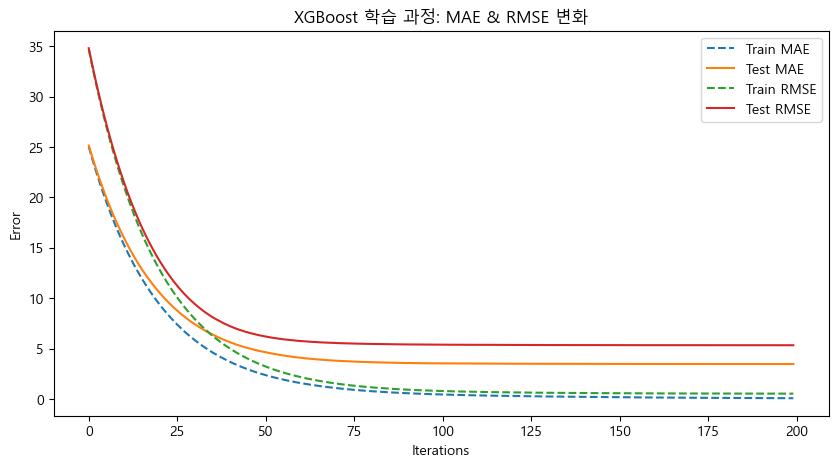

In [13]:
plt.rc('font', family='Malgun Gothic')
# MAE & RMSE 그래프 시각화
plt.figure(figsize=(10, 5))

# MAE 그래프
plt.plot(evals_result['train']['mae'], label="Train MAE", linestyle='--')
plt.plot(evals_result['test']['mae'], label="Test MAE")

# RMSE 그래프
plt.plot(evals_result['train']['rmse'], label="Train RMSE", linestyle='--')
plt.plot(evals_result['test']['rmse'], label="Test RMSE")

plt.xlabel("Iterations")
plt.ylabel("Error")
plt.title("XGBoost 학습 과정: MAE & RMSE 변화")
plt.legend()
plt.show()


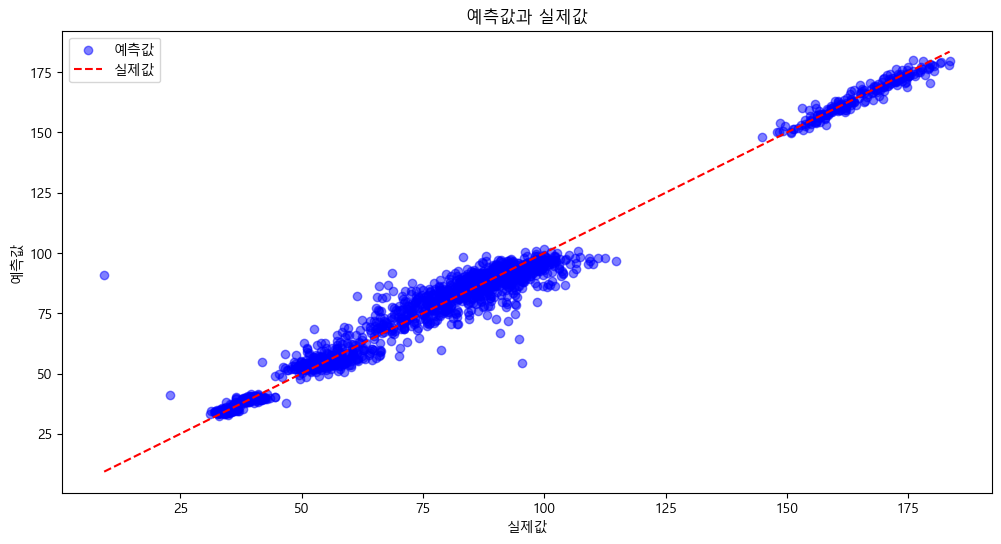

In [14]:
# y_test와 y_pred가 numpy 배열인지 확인 후 변환
y_test = np.array(y_test).flatten()
y_pred = np.array(y_pred).flatten()

plt.figure(figsize=(12, 6))
plt.scatter(y_test, y_pred, alpha=0.5, color="blue",label="예측값")  # 예측값 vs 실제값
plt.plot([np.min(y_test), np.max(y_test)], [np.min(y_test), np.max(y_test)], color="red", linestyle="--",label="실제값")  # 완벽한 예측선
plt.xlabel("실제값")
plt.ylabel("예측값")
plt.title("예측값과 실제값")
plt.legend()
plt.show()


C:\ai\IDE\anaconda\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


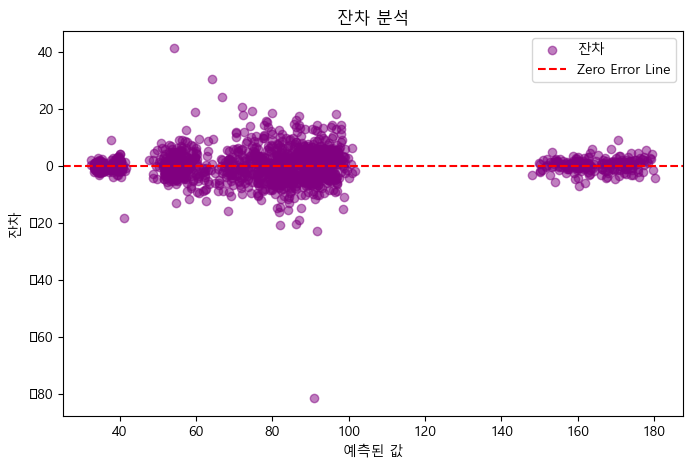

In [15]:
residuals = y_test - y_pred

plt.figure(figsize=(8, 5))
plt.scatter(y_pred, residuals, alpha=0.5, color="purple", label="잔차")
plt.axhline(y=0, color="red", linestyle="--", label="Zero Error Line")
plt.xlabel("예측된 값")
plt.ylabel("잔차")
plt.title("잔차 분석")
plt.legend()
plt.show()